In [24]:
import sys, site, platform, os
print("PYTHON:", sys.executable, platform.python_version())
print("USER-SITE:", site.getusersitepackages())

# If your Windows user-site has a corrupted matplotlib, remove it from this session:
bad_user_site = os.path.join(os.path.expanduser("~"), "AppData", "Roaming", "Python", "Python312", "site-packages")
if bad_user_site in sys.path:
    sys.path.remove(bad_user_site)
    print("Removed from sys.path for this session:", bad_user_site)

# Install (or ensure) packages into THIS interpreter
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install "numpy>=1.26" "pandas>=2.0" "matplotlib>=3.8,<3.10" "scikit-learn>=1.3"


PYTHON: /usr/bin/python3 3.12.11
USER-SITE: /root/.local/lib/python3.12/site-packages


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Imputation & modeling
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

plt.rcParams['figure.figsize'] = (10, 4)
pd.set_option('display.max_columns', 100)

DATA_PATH = Path("retail_sales.xlsx")


In [26]:
df = pd.read_excel(DATA_PATH)  # raises an error if file not found
print("Raw shape:", df.shape)
df.head()


Raw shape: (1000, 9)


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [27]:
# normalize headers
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

# parse date
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# coerce numerics (non-numeric -> NaN)
for c in ["quantity","price_per_unit","total_amount","age"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    1000 non-null   int64         
 1   date              1000 non-null   datetime64[ns]
 2   customer_id       1000 non-null   object        
 3   gender            1000 non-null   object        
 4   age               1000 non-null   int64         
 5   product_category  1000 non-null   object        
 6   quantity          1000 non-null   int64         
 7   price_per_unit    1000 non-null   int64         
 8   total_amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [28]:
print("Shape:", df.shape)
display(df.isna().sum().sort_values(ascending=False).to_frame("missing"))
print("Duplicate rows:", df.duplicated().sum())

# Descriptive statistics for numerics and key categoricals
desc_num = df.select_dtypes(include=[np.number]).describe().T
desc_num


Shape: (1000, 9)


,missing
transaction_id,0
date,0
customer_id,0
gender,0
age,0
product_category,0
quantity,0
price_per_unit,0
total_amount,0


Duplicate rows: 0


,count,mean,std,min,25%,50%,75%,max
transaction_id,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
age,1000.0,41.392,13.681430,18.0,29.00,42.0,53.00,64.0
quantity,1000.0,2.514,1.132734,1.0,1.00,3.0,4.00,4.0
price_per_unit,1000.0,179.890,189.681356,25.0,30.00,50.0,300.00,500.0
total_amount,1000.0,456.000,559.997632,25.0,60.00,135.0,900.00,2000.0


In [29]:
# Compute revenue deterministically (preferred)
if {"quantity","price_per_unit"}.issubset(df.columns):
    df["computed_total"] = df["quantity"] * df["price_per_unit"]
    df["revenue"] = df["computed_total"]
    if "total_amount" in df.columns:
        df["total_diff"] = np.round(df["total_amount"] - df["computed_total"], 2)
elif "total_amount" in df.columns:
    df["revenue"] = df["total_amount"]
else:
    raise ValueError("Need either (quantity & price_per_unit) or total_amount to analyze revenue.")

# Drop exact duplicates
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print("Dropped duplicates:", before - len(df))


Dropped duplicates: 0


In [30]:
# Categorical → 'Unknown'
for c in ["gender","product_category"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# Numeric → median (quick, explainable)
for c in ["quantity","price_per_unit","total_amount","age","revenue"]:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# Drop rows with missing date (cannot place on timeline)
if "date" in df.columns:
    before = len(df)
    df = df.dropna(subset=["date"]).reset_index(drop=True)
    print("Dropped rows with missing date:", before - len(df))

df.isna().sum()


Dropped rows with missing date: 0


,0
transaction_id,0
date,0
customer_id,0
gender,0
age,0
product_category,0
quantity,0
price_per_unit,0
total_amount,0
computed_total,0


In [31]:
num_cols = [c for c in ["quantity","price_per_unit","total_amount","age","revenue"] if c in df.columns]
if num_cols:
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])


In [32]:
if "date" in df.columns:
    df["year"]        = df["date"].dt.year
    df["month"]       = df["date"].dt.month
    df["day"]         = df["date"].dt.day
    df["dayofweek"]   = df["date"].dt.dayofweek           # 0=Mon..6=Sun
    df["weekday_name"]= df["date"].dt.day_name()
    df["quarter"]     = df["date"].dt.quarter
    df["weekofyear"]  = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"]  = df["dayofweek"].isin([5,6]).astype(int)

df.head()


,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,computed_total,revenue,total_diff,year,month,day,dayofweek,weekday_name,quarter,weekofyear,is_weekend
0,1,2023-11-24,CUST001,Male,34.0,Beauty,3.0,50.0,150.0,150,150.0,0,2023,11,24,4,Friday,4,47,0
1,2,2023-02-27,CUST002,Female,26.0,Clothing,2.0,500.0,1000.0,1000,1000.0,0,2023,2,27,0,Monday,1,9,0
2,3,2023-01-13,CUST003,Male,50.0,Electronics,1.0,30.0,30.0,30,30.0,0,2023,1,13,4,Friday,1,2,0
3,4,2023-05-21,CUST004,Male,37.0,Clothing,1.0,500.0,500.0,500,500.0,0,2023,5,21,6,Sunday,2,20,1
4,5,2023-05-06,CUST005,Male,30.0,Beauty,2.0,50.0,100.0,100,100.0,0,2023,5,6,5,Saturday,2,18,1


In [49]:
# Make sure time order is correct *within each customer*
if {'customer_id','date'}.issubset(df.columns):
    df = df.sort_values(['customer_id','date'])
elif 'date' in df.columns:
    df = df.sort_values(['date'])

# Use TRANSFORM, not apply, so the result aligns with df's index
if {'customer_id','revenue'}.issubset(df.columns):
    # Rolling by last N transactions (not time-based window)
    df['cust_roll3_rev_mean'] = (
        df.groupby('customer_id', sort=False)['revenue']
          .transform(lambda s: s.rolling(3, min_periods=1).mean())
    )

    df['cust_roll7_rev_mean'] = (
        df.groupby('customer_id', sort=False)['revenue']
          .transform(lambda s: s.rolling(7, min_periods=1).mean())
    )

    # Exponentially weighted mean (time-decaying recent spend)
    df['cust_ewm_rev'] = (
        df.groupby('customer_id', sort=False)['revenue']
          .transform(lambda s: s.ewm(alpha=0.3, adjust=False).mean())
    )


In [34]:
daily = (df.groupby("date")["revenue"]
           .sum()
           .sort_index()
           .rename("daily_sales")
           .to_frame())

# Rolling averages to reveal trend/seasonality
daily["roll7"]  = daily["daily_sales"].rolling(7,  min_periods=3).mean()
daily["roll28"] = daily["daily_sales"].rolling(28, min_periods=7).mean()

# Outliers: Z-score on daily sales
if daily["daily_sales"].std(ddof=0) > 0:
    z = (daily["daily_sales"] - daily["daily_sales"].mean()) / daily["daily_sales"].std(ddof=0)
    daily["outlier_flag"] = (z.abs() > 3).astype(int)
else:
    daily["outlier_flag"] = 0

daily.tail()


,daily_sales,roll7,roll28,outlier_flag
date,,,,
2023-12-27,700.0,1018.571429,1415.178571,0
2023-12-28,2075.0,1272.142857,1472.857143,0
2023-12-29,3400.0,1615.000000,1590.357143,0
2023-12-31,50.0,1357.857143,1483.928571,0
2024-01-01,1530.0,1547.857143,1517.142857,0


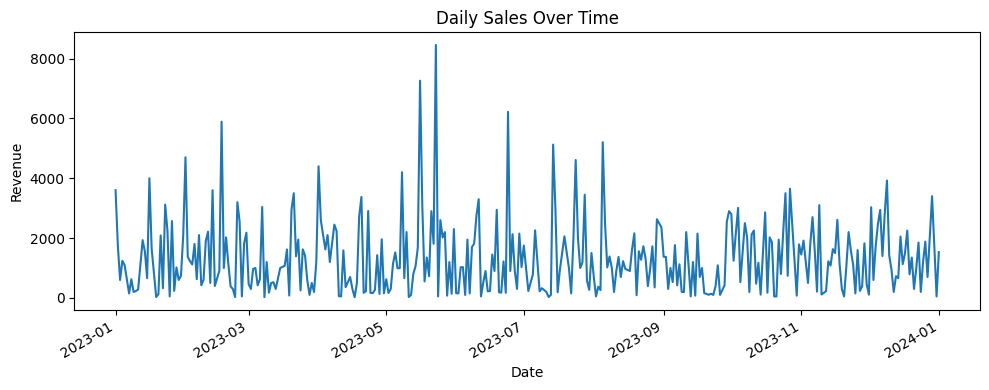

<Figure size 1000x400 with 0 Axes>

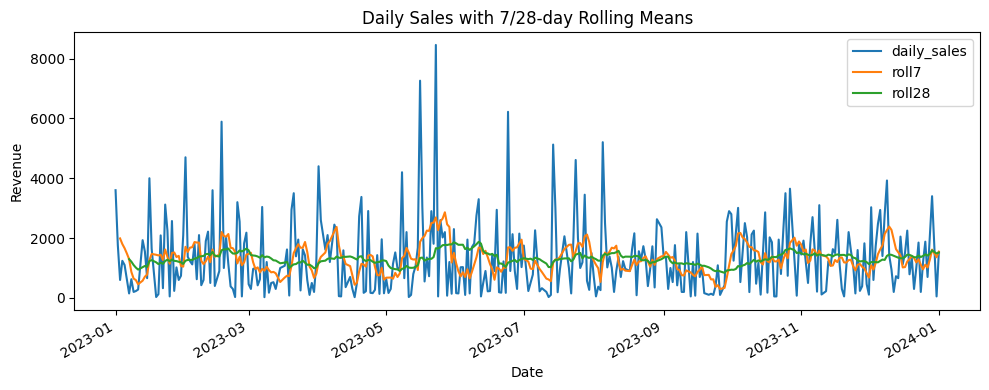

In [35]:
# Daily sales
plt.figure()
daily["daily_sales"].plot(title="Daily Sales Over Time")
plt.xlabel("Date"); plt.ylabel("Revenue"); plt.tight_layout(); plt.show()

# Rolling trends
plt.figure()
daily[["daily_sales","roll7","roll28"]].plot(title="Daily Sales with 7/28-day Rolling Means")
plt.xlabel("Date"); plt.ylabel("Revenue"); plt.tight_layout(); plt.show()


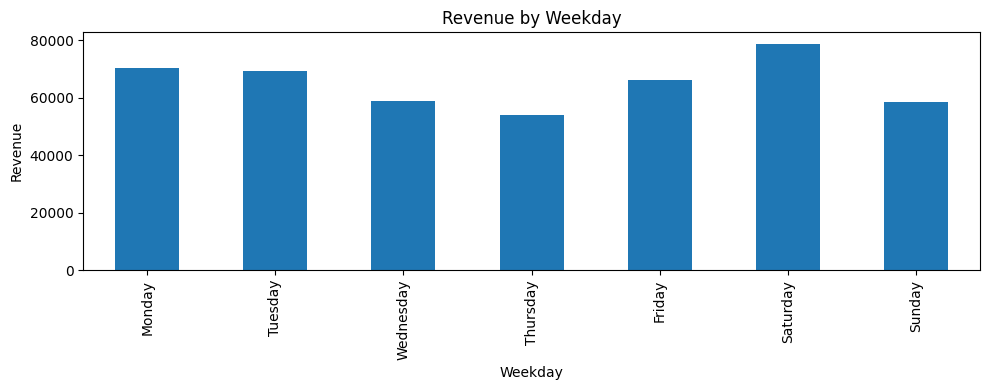

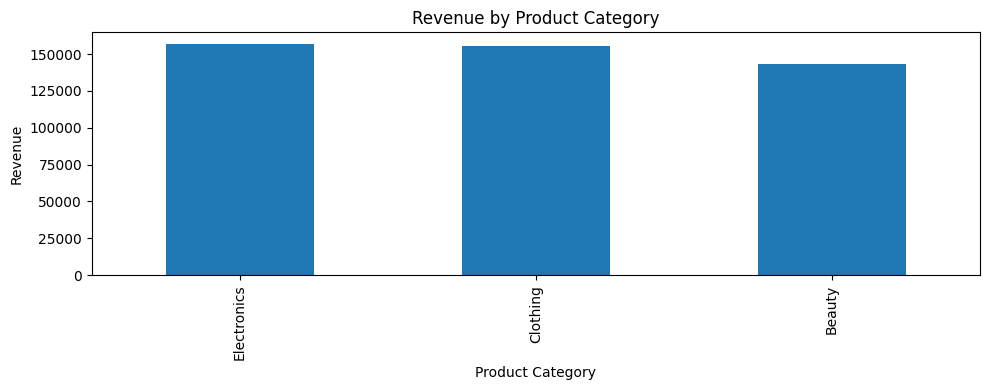

In [36]:
if {"weekday_name","revenue"}.issubset(df.columns):
    by_wd = (df.groupby("weekday_name")["revenue"].sum()
               .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]))
    plt.figure(); by_wd.plot(kind="bar", title="Revenue by Weekday")
    plt.xlabel("Weekday"); plt.ylabel("Revenue"); plt.tight_layout(); plt.show()

if {"product_category","revenue"}.issubset(df.columns):
    by_cat = df.groupby("product_category")["revenue"].sum().sort_values(ascending=False)
    plt.figure(); by_cat.plot(kind="bar", title="Revenue by Product Category")
    plt.xlabel("Product Category"); plt.ylabel("Revenue"); plt.tight_layout(); plt.show()


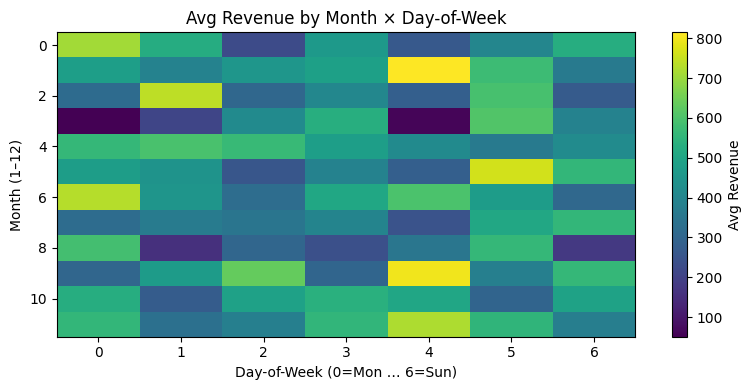

In [37]:
if {"month","dayofweek","revenue"}.issubset(df.columns):
    pivot = (df.groupby(["month","dayofweek"])["revenue"].mean().unstack())
    plt.figure(figsize=(8,4))
    plt.imshow(pivot.values, aspect="auto")
    plt.title("Avg Revenue by Month × Day-of-Week")
    plt.xlabel("Day-of-Week (0=Mon … 6=Sun)"); plt.ylabel("Month (1–12)")
    plt.colorbar(label="Avg Revenue"); plt.tight_layout(); plt.show()


In [39]:
try:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=daily.index.min(), end=daily.index.max())
    daily["is_us_holiday"] = daily.index.isin(holidays).astype(int)
    holiday_vs_not = daily.groupby("is_us_holiday")["daily_sales"].mean().rename({0:"Non-Holiday",1:"Holiday"})
    holiday_vs_not
except Exception as e:
    print("Holiday effect skipped:", e)


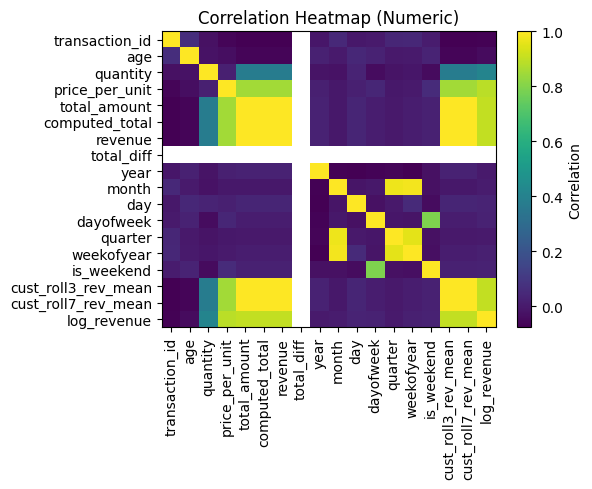

In [40]:
num_df = df.select_dtypes(include=[np.number]).copy()
if "revenue" in num_df.columns:
    # Log transform revenue to reduce skew (safe log1p)
    num_df["log_revenue"] = np.log1p(num_df["revenue"])

corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric)")
plt.tight_layout(); plt.show()


In [41]:
rfm = None
if {"customer_id","date","revenue"}.issubset(df.columns):
    today = df["date"].max()
    grp = df.sort_values("date").groupby("customer_id")
    last_date = grp["date"].max()
    freq = grp.size()
    mon  = grp["revenue"].sum()
    rfm = pd.DataFrame({
        "recency_days": (today - last_date).dt.days,
        "frequency": freq,
        "monetary": mon
    }).sort_values("monetary", ascending=False)
    rfm.describe()


In [42]:
if {"product_category","revenue"}.issubset(df.columns):
    te = df.groupby("product_category")["revenue"].mean().rename("te_product_category")
    df = df.merge(te, on="product_category", how="left")
    df[["product_category","te_product_category"]].head()


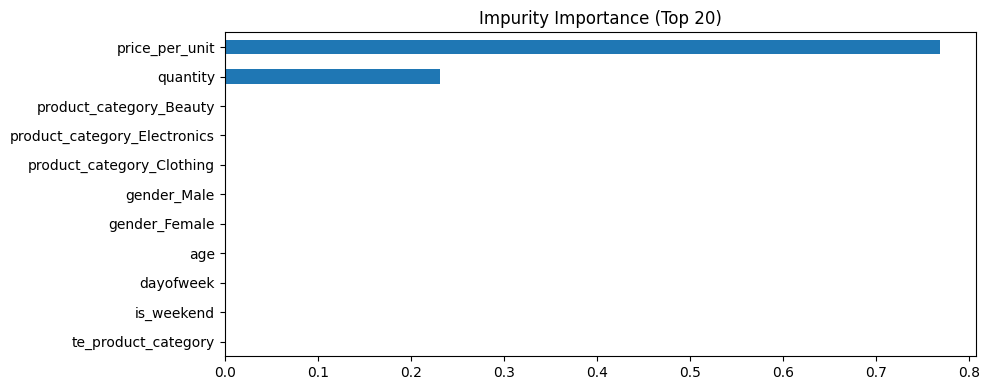

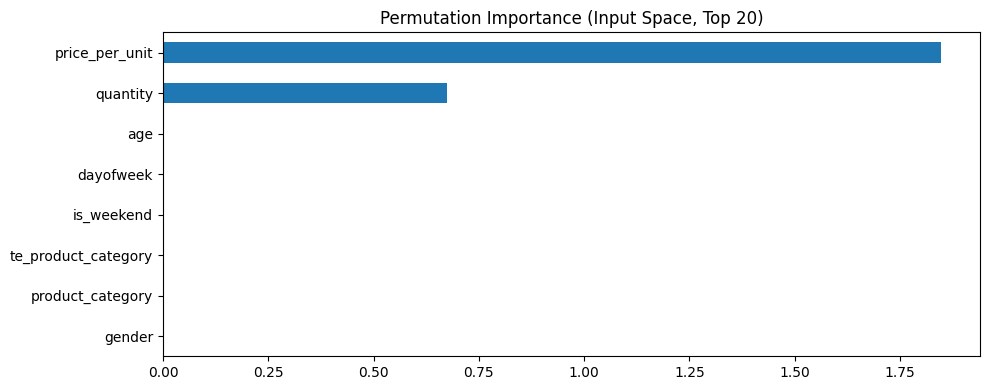

In [47]:
# 1) Impurity-based importance (expanded space) — unchanged
ohe = pipe.named_steps['prep'].named_transformers_['onehot'] if cat_cols else None
ohe_feats = list(ohe.get_feature_names_out(cat_cols)) if ohe is not None else []
final_feats = ohe_feats + num_cols

imp = pd.Series(pipe.named_steps['rf'].feature_importances_, index=final_feats).sort_values(ascending=False)
plt.figure(); imp.iloc[::-1][:20].plot(kind='barh', title='Impurity Importance (Top 20)')
plt.tight_layout(); plt.show()

# 2) Permutation importance (INPUT space) — FIXED index
r = permutation_importance(pipe, X_te, y_te, n_repeats=10, random_state=42)
perm_input = pd.Series(r.importances_mean, index=features).sort_values(ascending=False)

plt.figure(); perm_input.iloc[::-1][:20].plot(kind='barh', title='Permutation Importance (Input Space, Top 20)')
plt.tight_layout(); plt.show()


RandomForest R^2 (quantity holdout): -0.216


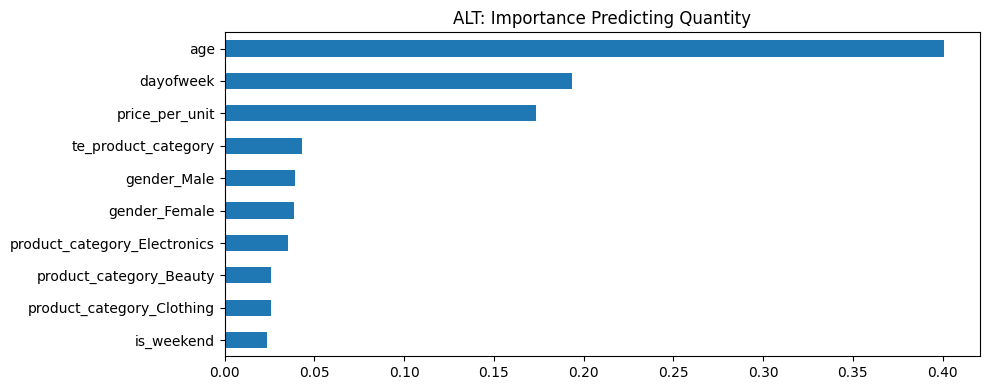

In [44]:
if "quantity" in df.columns:
    alt_target = "quantity"
    alt_feats  = [c for c in ["price_per_unit","age","dayofweek","is_weekend","te_product_category","product_category","gender"] if c in df.columns]
    X2 = df[alt_feats].copy(); y2 = df[alt_target].values

    cat2 = [c for c in ["product_category","gender"] if c in X2.columns]
    num2 = [c for c in X2.columns if c not in cat2]

    pre2  = ColumnTransformer([("onehot", OneHotEncoder(handle_unknown="ignore"), cat2)], remainder="passthrough")
    pipe2 = Pipeline([("prep", pre2), ("rf", RandomForestRegressor(n_estimators=200, random_state=42))])

    X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.2, random_state=42)
    pipe2.fit(X2_tr, y2_tr)
    print("RandomForest R^2 (quantity holdout):", round(pipe2.score(X2_te, y2_te), 3))

    ohe2 = pipe2.named_steps["prep"].named_transformers_["onehot"] if cat2 else None
    ohe_feats2 = list(ohe2.get_feature_names_out(cat2)) if ohe2 is not None else []
    final2 = ohe_feats2 + num2

    imp2 = pd.Series(pipe2.named_steps["rf"].feature_importances_, index=final2).sort_values(ascending=False)
    plt.figure(); imp2.iloc[::-1][:20].plot(kind="barh", title="ALT: Importance Predicting Quantity")
    plt.tight_layout(); plt.show()


In [45]:
df.to_csv("retail_sales_clean.csv", index=False)
daily.to_csv("retail_daily_aggregates.csv")
print("Saved: retail_sales_clean.csv, retail_daily_aggregates.csv")


Saved: retail_sales_clean.csv, retail_daily_aggregates.csv
